<center><h1>Building A Handwritten Digits Classifier<h1><center>
    
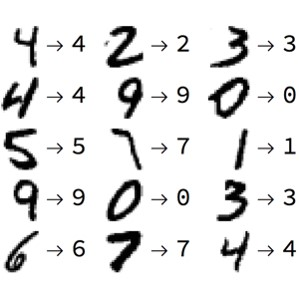

# Image Classification

**Why is image classification a hard task?**

Within the field of machine learning and pattern recognition, image classification (especially for handwritten text) is towards the difficult end of the spectrum. There are a few reasons for this.

First, each image in a training set is high dimensional. Each pixel in an image is a feature and a separate column. This means that a 128 x 128 image has 16384 features.

Second, images are often downsampled to lower resolutions and transformed to grayscale (no color). This is a limitation of compute power unfortunately. The resolution of a 8 megapixel photo has 3264 by 2448 pixels, for a total of 7,990,272 features (or about 8 million). Images of this resolution are usually scaled down to between 128 and 512 pixels in either direction for significantly faster processing. This often results in a loss of detail that's available for training and pattern matching.

Third, the features in an image don't have an obvious linear or nonlinear relationship that can be learned with a model like linear or logistic regression. In grayscale, each pixel is just represented as a brightness value ranging from 0 to 256.

## Project Goal

In this Guided Project, I'll explore the effectiveness of deep, feedforward neural networks at classifying images as follows:

- explore why image classification is a hard task
- observe the limitations of traditional machine learning models for image classification
- train, test, and improve a few different deep neural networks for image classification

In [1]:
# import key python libraries to perform desired excutions.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

digits_data = load_digits()

## Download Dataset

Rather than using the pd.read_csv command, I will use the <span style="color:lime">load_digits()</span> function shown below to return a copy of the hand-written digits dataset from UCI (University of California, Irvine). The dataset is available to observe [<span style="color:red">here.</span>](https://archive.ics.uci.edu/ml/datasets/optical+recognition+of+handwritten+digits 'here')

In [2]:
digits_data.keys()

labels = pd.Series(digits_data['target'])

data = pd.DataFrame(digits_data['data'])
data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0


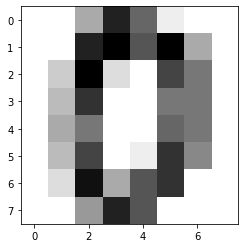

In [3]:
first_image = data.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(8,8)

plt.imshow(np_image, cmap='gray_r')

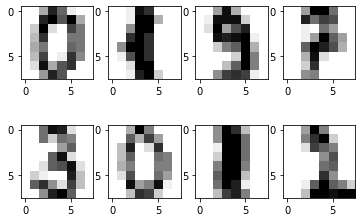

In [4]:
f, axarr = plt.subplots(2, 4)

axarr[0, 0].imshow(data.iloc[0].values.reshape(8,8), cmap='gray_r')
axarr[0, 1].imshow(data.iloc[99].values.reshape(8,8), cmap='gray_r')
axarr[0, 2].imshow(data.iloc[199].values.reshape(8,8), cmap='gray_r')
axarr[0, 3].imshow(data.iloc[299].values.reshape(8,8), cmap='gray_r')

axarr[1, 0].imshow(data.iloc[999].values.reshape(8,8), cmap='gray_r')
axarr[1, 1].imshow(data.iloc[1099].values.reshape(8,8), cmap='gray_r')
axarr[1, 2].imshow(data.iloc[1199].values.reshape(8,8), cmap='gray_r')
axarr[1, 3].imshow(data.iloc[1299].values.reshape(8,8), cmap='gray_r')

## K-Nearest Neighbors Model

In [5]:

# 50% Train / test validation
def train_knn(nneighbors, train_features, train_labels):
    knn = KNeighborsClassifier(n_neighbors = nneighbors)
    knn.fit(train_features, train_labels)
    return knn

def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    train_test_df = pd.DataFrame()
    train_test_df['correct_label'] = test_labels
    train_test_df['predicted_label'] = predictions
    overall_accuracy = sum(train_test_df["predicted_label"] == train_test_df["correct_label"])/len(train_test_df)    
    return overall_accuracy

def cross_validate(k):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        model = train_knn(k, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

for n in range(1,5):
    knn_one_accuracies = cross_validate(n)
    acc_mean = np.mean(knn_one_accuracies)
    print('{:.5f}'.format(acc_mean))

0.98887
0.98219
0.98720
0.98331


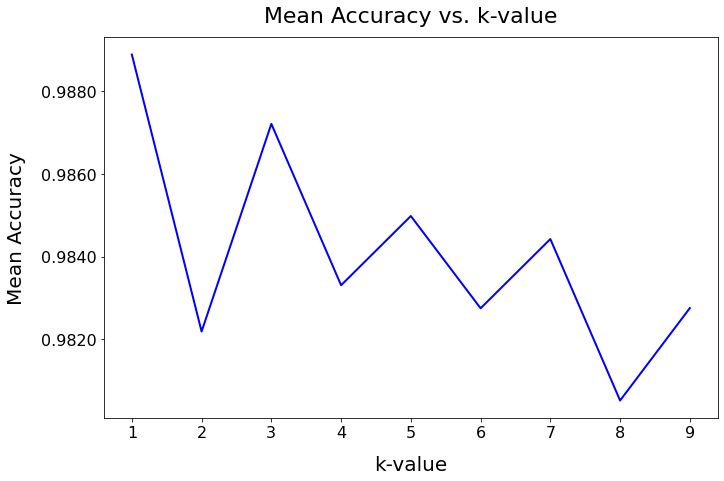

In [6]:
k_values = list(range(1,10))
k_overall_accuracies = []

for k in k_values:
    k_accuracies = cross_validate(k)
    k_mean_accuracy = np.mean(k_accuracies)
    k_overall_accuracies.append(k_mean_accuracy)

fig,ax = plt.subplots(figsize=(11,7))
plt.title('Mean Accuracy vs. k-value', fontsize=22, pad=15)
plt.plot(k_values, k_overall_accuracies, linewidth=2, c='blue')
plt.xlabel('k-value', fontsize=20, labelpad=15)
plt.ylabel('Mean Accuracy', fontsize=20, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
plt.show()

## Observations

The graph above shows a general downward trend for mean accuracy as k-value increases: not by a large amount, but still a slight reduction in mean accuracy.

## Neural Network With One Hidden Layer

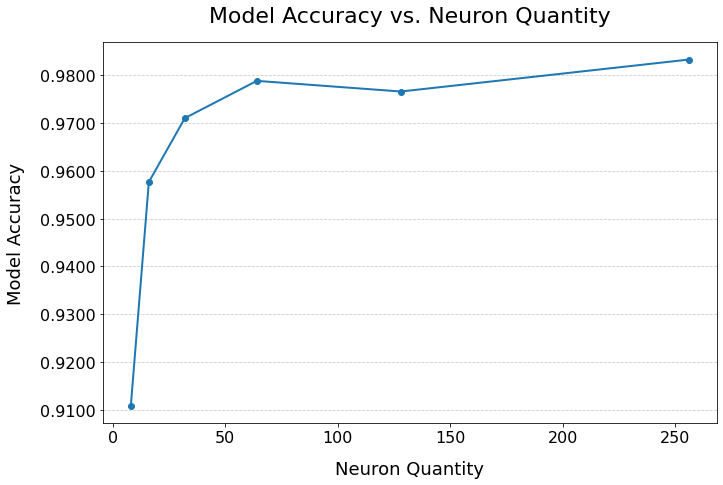

In [7]:
kf = KFold(n_splits = 2, random_state=2, shuffle=True)
for train_index, test_index in kf.split(data):
    train_features, test_features = data.loc[train_index], data.loc[test_index]
    train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]


accuracies = []
neurons = [8, 16, 32, 64, 128, 256]
for n in neurons:
    mlp = MLPClassifier(hidden_layer_sizes=(n,), activation='logistic')
    mlp.fit(train_features, train_labels)
    nn_predictions = mlp.predict(test_features)
    accuracy = accuracy_score(test_labels, nn_predictions)
    accuracies.append(accuracy)
fig,ax = plt.subplots(figsize=(11,7))
ax.yaxis.grid(linestyle='dashed', color='grey', alpha=0.4) # horizontal lines

x = neurons
y = accuracies
plt.title('Model Accuracy vs. Neuron Quantity', fontsize=22, pad=20)
plt.plot(x,y, linewidth=2, marker='o')
plt.xlabel('Neuron Quantity', fontsize=18, labelpad=15)
plt.ylabel('Model Accuracy', fontsize=18, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
plt.show()
    

## Observations: Neural Network w/ One Hidden Layer

The graph above shows me that the slope of model accuracy is very high when increasing from low quanities of neurons and then tapers off and levels out.

The magnitude of model accuracy reaches at least 98%.

## Neural Network With Two Hidden Layers

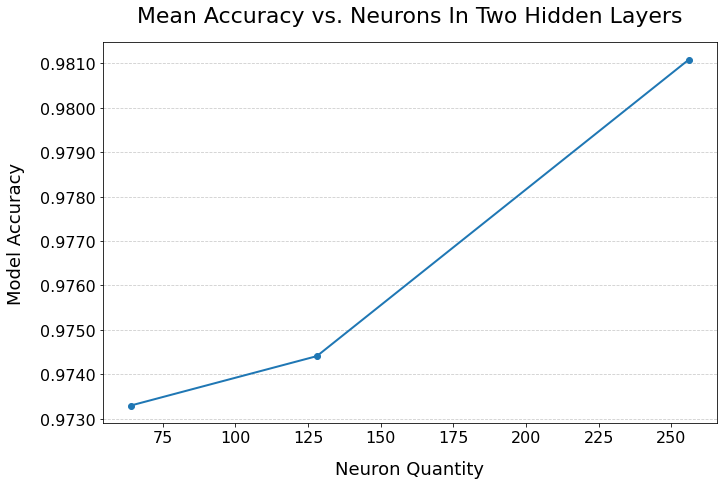

nn_two_accuracies = 0.97329, 0.97441, 0.98109


In [8]:
# 50% train / test validation
def train_nn(neuron_arch, train_features, train_labels):
    mlp = MLPClassifier(hidden_layer_sizes=neuron_arch)
    mlp.fit(train_features, train_labels)
    return mlp

# cross-validation
def cross_validate(neuron_arch):
    fold_accuracies = []
    kf = KFold(n_splits = 4, random_state=2, shuffle=True)
    for train_index, test_index in kf.split(data):
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
       
        model = train_nn(neuron_arch, train_features, train_labels)
        overall_accuracy = test(model, test_features, test_labels)
        fold_accuracies.append(overall_accuracy)
    return fold_accuracies

nn_two_neurons = [
    (64,64),
    (128, 128),
    (256, 256)]
nn_two_accuracies = []

for n in nn_two_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_two_accuracies.append(nn_mean_accuracy)

fig,ax = plt.subplots(figsize=(11,7))
ax.yaxis.grid(linestyle='dashed', color='grey', alpha=0.4) # horizontal lines
plt.title('Mean Accuracy vs. Neurons In Two Hidden Layers',  fontsize=22, pad=20)
plt.xlabel('Neuron Quantity', fontsize=18, labelpad=15)
plt.ylabel('Model Accuracy', fontsize=18, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
x = [i[0] for i in nn_two_neurons]
plt.plot(x, nn_two_accuracies, linewidth=2, marker='o')
plt.show()

Q = nn_two_accuracies
fmtL = "nn_two_accuracies = " + ', '.join(["{:.5f}"]*len(Q))
print(fmtL.format(*Q))

## Observations: Neural Network w/ Two Hidden Layers

The graph above is much the same in pattern as the one further above for one hidden layer.

The magnitude of model accuracy reaches at least 98%.

## Neural Network With Three Hidden Layers

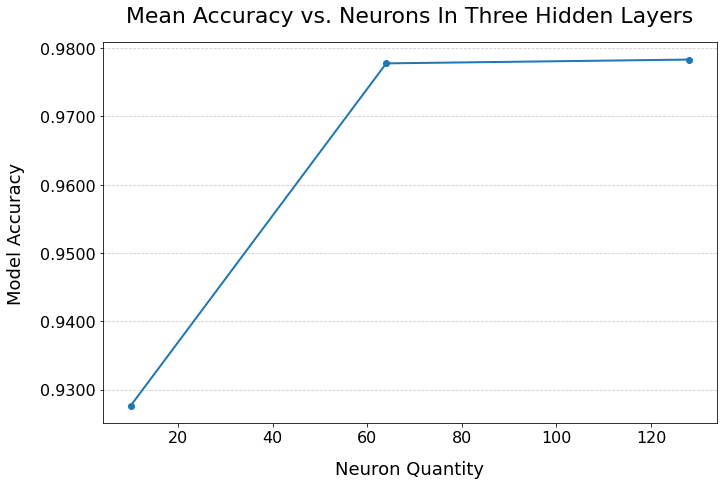

nn_three_accuracies = 0.92766, 0.97774, 0.97830


In [9]:
nn_three_neurons = [
    (10,10,10),
    (64, 64, 64),
    (128, 128, 128)]
nn_three_accuracies = []

for n in nn_three_neurons:
    nn_accuracies = cross_validate(n)
    nn_mean_accuracy = np.mean(nn_accuracies)
    nn_three_accuracies.append(nn_mean_accuracy)

fig,ax = plt.subplots(figsize=(11,7))
ax.yaxis.grid(linestyle='dashed', color='grey', alpha=0.4) # horizontal lines
plt.title('Mean Accuracy vs. Neurons In Three Hidden Layers',  fontsize=22, pad=20)
plt.xlabel('Neuron Quantity', fontsize=18, labelpad=15)
plt.ylabel('Model Accuracy', fontsize=18, labelpad=15)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
x = [i[0] for i in nn_three_neurons]
plt.plot(x, nn_three_accuracies, linewidth=2, marker='o')
plt.show()

Q2 = nn_three_accuracies
fmtL = "nn_three_accuracies = " + ', '.join(["{:.5f}"]*len(Q2))
print(fmtL.format(*Q2))   

## Observations: Neural Network w/ Three Hidden Layers

The graph above is much the same in pattern as the one further above for one and two hidden layers. Higher quantity of neuronas increasaes model accuracy.

The magnitude of model accuracy reaches close to 98%.

## Conclusions

In using K-Fold Cross Validation and Neural Network along with various parameter settings, number of K-Folds, number of neurons and number of hidden layers, it was very interesting to see how they impacted model accuracy.

In general, the model accuracy with the right combination of parameter settings was very high, reaching 98% which is very impressive.